In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from stop_words import get_stop_words
import re
import itertools
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv' , sep='\t')

In [3]:
def split_categories(category):
    try:
        main_cat1,sub_cat1,sub_cat2 = category.split("/")
        return main_cat1,sub_cat1,sub_cat2
    except:
        return 'No Category','No Category','No Category'

In [4]:
train['main_cat'],train['sub_cat1'],train['sub_cat2'] = zip(*train['category_name'].apply(lambda x: split_categories(x)))
test['main_cat'],test['sub_cat1'],test['sub_cat2'] = zip(*test['category_name'].apply(lambda x: split_categories(x)))

In [5]:
train['log_price'] = np.log1p(train['price'])

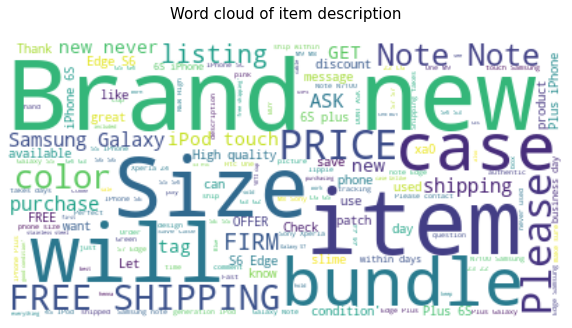

In [6]:
word_counter = Counter(train['item_description'])
most_common_words = word_counter.most_common(500)

stopwords = get_stop_words('en')
stopwords.extend(['rm'])  
#it is mentioned that information given to us is in a formatted way and it doesn't show text given in 
#dollar terms instead we get rm in it's place so it is added as aditional stop words since it occurences have 
#no effect on our prices

#here is the link to original mercari dataset where it is explained
#https://www.kaggle.com/c/mercari-price-suggestion-challenge/data

wordcloud = WordCloud(stopwords=stopwords,background_color='white').generate(str(most_common_words))

plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Word cloud of item description\n',fontsize=15)
plt.axis('off')
plt.show()

In [7]:
train['description_wc']=[len(str(i).split()) for i in train['item_description']]
train['name_wc']=[len(str(i).split()) for i in train['name']]

# Data Cleaning

### Here we will deal with items for which prices are zero and these enteries are completely useless to us while predicting the prices so we delete them

In [8]:
train = train.drop(train[(train['price']==0.0)].index)

### Above we found out that there were null values in our dataset so now we will deal with those values. for category_name we already handled the null values above when we were splitting categories now for brand name and item description we use 'fillna' to replace null values by 'Not Known' and 'No Description' respectively.

In [9]:
train['brand_name'] = train['brand_name'].fillna('Not Known')
train['item_description'] = train['item_description'].fillna('No Description Yet')

### There are lot of phrases which in the apostrophe form and we will replace them with there actual name because later on when we remove punctuation it will be really hard to get there right meaning

In [10]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
train['item_description'].apply(decontracted)

0          A brand-new, unused, unopened, undamaged item....
1           Color is gold deposit, about 85% of product left
2              New Ultra thin Candy TPU Silicone Rubber Soft
3          VS sexy little thing multi way bras both size ...
4                                          New with out box!
                                 ...                        
1037769                          Like new. Sz L. Thumb holes
1037770    ❤️❤️Sadly reselling because they are a little ...
1037771    NWT Unisex Ribbed cable knit beanie slouchy th...
1037772                                   In great condition
1037773    Dark burgundy Size 10 Excellent like new condi...
Name: item_description, Length: 1037170, dtype: object

### Short item description of 1 or 2 word doesn't help us in predicting the prices in any way. infact opposite it will reduce performance so we delete them

In [13]:
train = train[train['description_wc'] >= 3]

### To check whether there are some duplicate value in our name,item_description 

In [14]:
print(sum(train.duplicated('name')))
print(sum(train.duplicated('item_description')))

149063
104261


In [15]:
train.sort_values('name',inplace=True)

### In e-commerce there are multiple product being sold with same name. ex:- suppose you are selling a shirt and you have it in different color. then it is being considered as 4 different product instead of 1. so to deal with such cases we use the method below. i.e. first sorting the data based on name and then removing duplicates

In [16]:
indices = []
for i,row in train.iterrows():
    indices.append(i)

In [17]:
dupe = []
i = 0
j = 0
num_data_points = train.shape[0]

while i < num_data_points and j < num_data_points:
    previous_i = i
    a = train['name'].loc[indices[i]].split()
    j = i + 1
    while j < num_data_points:
        b = train['name'].loc[indices[j]].split()
        length = max(len(a),len(b))
        count = 0
        for k in itertools.zip_longest(a,b):
            if (k[0] == k[1]):
                count += 1
                
        if (length - count) > 2:
            dupe.append(train['train_id'].loc[indices[i]])
            
            if j == num_data_points - 1:
                dupe.append(train['train_id'].loc[indices[i]])
            
            i = j
            break
        else:
            j+=1
    if previous_i == i:
        break

In [19]:
train = train.loc[train['train_id'].isin(dupe)]

# Text Preprocessing

In [20]:
def remove_punct(token):
    x = [i for i in token if i.isalnum()]
    return x

def lower(token):
    x = [i.lower() for i in token]
    return x

def remove_stopwords(token):
    x = [i for i in token if not i in stopwords]
    return x

def stemmer(token):
    porter = PorterStemmer()
    x = [porter.stem(i) for i in token]
    return x

def lemmatizer(token):
    lemmatizer = WordNetLemmatizer() 
    x = [lemmatizer.lemmatize(i) for i in token]
    return x

## Text Preprocessing of name

### Converting our names into tokens

In [21]:
train['tokenized_name'] = train.apply(lambda x:word_tokenize(str(x['name'])),axis = 1)

### Removing punctuations

In [ ]:
train['tokenized_name'] = train['tokenized_name'].apply(remove_punct)

### Converting all the values in column to lower case

In [22]:
train['tokenized_name'] = train['tokenized_name'].apply(lower)

### Removing Stopwords

In [23]:
train['tokenized_name'] = train['tokenized_name'].apply(remove_stopwords)

### Performing stemming which is the process of converting a word into it's base or root room. ex:- converting flying into fly

In [24]:
train['tokenized_name'] = train['tokenized_name'].apply(stemmer)

### Performing lemitization which  is the algorithmic process of determining the lemma of a word based on its intended meaning. ex:- better is same as good

In [25]:
train['tokenized_name'] = train['tokenized_name'].apply(lemmatizer)

## Text Preprocessing of Description

### Converting our item_description into tokens

In [ ]:
train['tokenized_description'] = train.apply(lambda x:word_tokenize(str(x['item_description'])),axis = 1)

### Removing punctuations

In [ ]:
train['tokenized_description'] = train['tokenized_description'].apply(remove_punct)

### Converting all the values in column to lower case

In [ ]:
train['tokenized_description'] = train['tokenized_description'].apply(lower)

### Removing stopwords

In [ ]:
train['tokenized_description'] = train['tokenized_description'].apply(remove_stopwords)

### Performing stemming which is the process of converting a word into it's base or root room. ex:- converting flying into fly

In [ ]:
train['tokenized_description'] = train['tokenized_description'].apply(stemmer)

### Performing lemitization which  is the algorithmic process of determining the lemma of a word based on its intended meaning.ex:- better is same as good

In [ ]:
train['tokenized_description'] = train['tokenized_description'].apply(lemmatizer)